In [92]:
import numpy as np
from numpy import sin,cos,exp,tan,log,log10

import scipy as s
from scipy.integrate import odeint
from scipy import pi

import matplotlib.pyplot as plt
import time

In [113]:
# physical parameters
a = 0.05   # radius of tube (m)
H = 10  # length of tube (m)
h = 0.01   # thinckness of tube (m)
sigma = 5.92e7   # conductivity of tube material (Siemens)
mu = 4*pi*1e-7   # magnetic permeability
m = 2   # dipole moment (A/m^2)
M = 0.0030   # mass of magnet (kg)
g = 9.81   # gravity acceleration (N/kg)


# simulation parameters
t_max = 10
max_iter = 15000   # total number of iterations in time
dt = t_max/max_iter

init_height = 0.02*H # setting the initial condition z[0]
init_displ = 0.2*a  # setting the initial condition x[0]

N = 100  # number of ring partitions of tube
dH = H/N   # height of one ring
R = 2*pi*a/(sigma*h*dH)   # resistance of one ring (Ohm)
Z_ring = -(np.arange(N)+1/2) * dH   # array that stores effective positions of rings (midpoints in z)
#print(Z_ring/dH)




def emf(x,z,vz):
    """This function calculates the e.m.f. by doing integral "v cross B" along the body of the ring, neglecting the vx component
    of motion, which is much smaller than vz component."""
    v = z/a
    u = x/a
    integral =  s.integrate.quad(lambda phi: v * (1 - u*cos(phi)) / (1 + u**2 - 2*u*cos(phi) + v**2)**(5/2), 0, 2*pi )
    integral = integral[0]
    integral *= - 3 * mu/4/pi * m * vz / a**2
    return integral


def force_z(x,z,J):
    """Magnetic force of an elemental ring in z-direction, argument z interpreted as z(magnet) - z_ring"""
    u = x/a
    v = z/a
    integral = s.integrate.quad(lambda phi: v * (1 - u*cos(phi)) / (1 + u**2 + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral = integral[0]
    integral *= + 3 * mu/4/pi * m / a**2 * J
    return integral
    
def force_x(x,z,J):
    """Magnetic force of an elemental ring in x-direction, argument z interpreted as z(magnet) - z_ring"""
    u = x/a
    v = z/a
    integral = s.integrate.quad(lambda phi: cos(phi) * (1 + u**2  - 2*v**2 - 2*u*cos(phi)) / (1 + u**2  + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral = integral[0]
    integral *= +  mu/4/pi * m / a**2 * J
    return integral



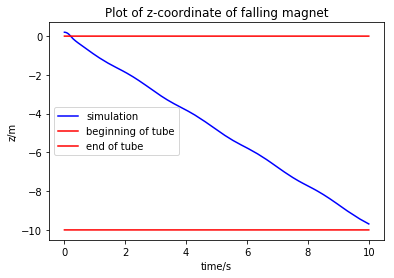

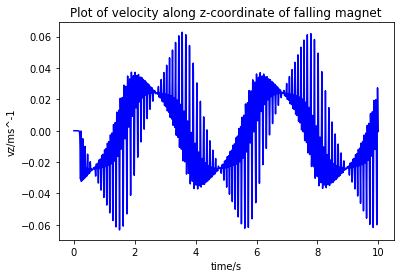

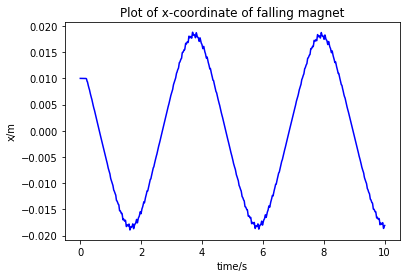

final coordinate of magnet, in cm: -969.16
and in case of free fall, in cm:   -49030.00


simulation took 610.64 s


In [114]:
# initiate arrays that store our data

T = np.linspace(0,t_max,max_iter)   # array that stores all points in time 

z = np.zeros((max_iter))   # array that stores coordinates of magnet along axes as time progresses
vz = np.zeros((max_iter))
az = np.zeros((max_iter))

x = np.zeros((max_iter))   # array that stores radial coordinates of magnet in x-z plane as time progresses
vx = np.zeros((max_iter))
ax = np.zeros((max_iter))

J = np.zeros((max_iter,N))  # array that stores currents (in Amperes) in all rings as time progresses
Fx = np.zeros((max_iter,N)) # array that stores lateral forces (in Newtons) in all rings as time progresses
Fz = np.zeros((max_iter,N)) # array that stores vertical forces (in Newtons) in all rings as time progresses



# now implement ICs to get values for first two iterations

z[0] = init_height
az[0] = -g
vz[0] = 1/2*dt*az[0] # vz[0] is in fact vz[1/2], all indices for velocity are shifted forwards by 1/2
z[1] = z[0] + vz[0]*dt

x[0] = init_displ
ax[0] = 0
vx[0] = 1/2*dt*ax[0] # vx[0] is in fact vx[1/2], all indices for velocity are shifted forwards by 1/2
x[1] = x[0] + vx[0]*dt

J[0,:] = 0
J[1,:] = 1/R * emf(x[1],z[1],vz[0]+1/2*dt*az[0])  # use extrapolated velocity between V[1/2] and V[3/2] to approximate V[1]



# solve using an improved finite difference approach "x[t+dt] = x[t] + dt*x'[t+1/2*dt]"

sim_start = time.time()

for i in range(1,max_iter-1):
        
    for n in range(N):  # quite stupid way, should later vectorize, but probably would not make much difference,
                        # as looping is likely negligible compared to all these horrible numerical integrations
        Fx[i,n] = force_x(x[i], z[i]-Z_ring[n], J[i,n])
        Fz[i,n] = force_z(x[i], z[i]-Z_ring[n], J[i,n])
        
    ax[i] = 1/M * sum(Fx[i,:])   # sum all forces corresponding to separate rings at iteration i
    az[i] = -g + 1/M * sum(Fz[i,:])
    
    vx[i] = vx[i-1] + ax[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    vz[i] = vz[i-1] + az[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    
    x[i+1] = x[i] + vx[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    z[i+1] = z[i] + vz[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    
    for n in range(N):
        J[i+1,n] = 1/R * emf(x[i+1], z[i+1]-Z_ring[n],vz[i]+1/2*dt*az[i]) # e.g. for i=1: J[2] = f( Z[2], V[3/2]+A[2]*1/2*dt )

sim_end = time.time()    
    
    
    
plt.plot(T,z,'b',label='simulation')
#plt.plot(T,init_height-1/2*g*T**2,'g',label='free fall')
plt.plot(T, 0*np.ones(max_iter),'r', label='beginning of tube')
plt.plot(T, -H*np.ones(max_iter),'r', label='end of tube')
plt.legend()
plt.xlabel('time/s')
plt.ylabel('z/m')
plt.title('Plot of z-coordinate of falling magnet')
plt.show()

plt.plot(T,vx,'b')
plt.xlabel('time/s')
plt.ylabel('vz/ms^-1')
plt.title('Plot of velocity along z-coordinate of falling magnet')
plt.show()

plt.plot(T,x,'b',label='simulation')
plt.xlabel('time/s')
plt.ylabel('x/m')
plt.title('Plot of x-coordinate of falling magnet')
plt.show()

ref = -65.1665
print("final coordinate of magnet, in cm:","{:.2f}".format(z[-1]*100))
#print("value from ref. simulation, in cm:", ref)
print("and in case of free fall, in cm:  ","{:.2f}".format((init_height-1/2*g*T[-1]**2)*100))
print()
#print("percentage error of reduction in free-fall distance from reference:  ",(z[-1]*100-ref)/((init_height-1/2*g*T[-1]**2)*100 - ref) * 100,"%")
print()
print("simulation took","{:.2f}".format(sim_end-sim_start),"s")


In [103]:
"{:.2f}".format(pi)

'3.14'